In [ ]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import importlib
from warnings import simplefilter
from six import StringIO
from IPython.display import Image

# Reload external files
import importlib

# Mute warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

import datetime

from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import os

# Load data

## Load raw data

### Market data

In [ ]:
# Change function of EOD because we use Compustat....
# In the end, add all used Excel files to this repo, we have: stock_universe_new.joblib, SP500H_EOD_raw, SP500H_RP_SESI (if we only use daily SESI score and no other sentiment feature types)
# We use EOD for the list of historical components
# At the end, just do all data steps one more time 

In [ ]:
# Choose data location, EOD, SQL or CSV, Compustat
str_load_data = "CSV"

In [ ]:
# Loads raw data, data cleaning and transformation is needed after this
import Load_data
importlib.reload(Load_data)

if str_load_data == "EOD_old_method":
    
    # Index name 
    str_index_name = "S&P500_historical"

    # Loads market data from EOD
    ar_index, df_index = Load_data.create_stock_universe_old(str_index_name)
    df = Load_data.load_EOD(ar_index)

    df = Load_data.create_historical_SP_Index_old_method(df_index, df)            

    # Adds lags and returns
    df = Load_data.add_lags(df)

if str_load_data == "EOD_new_method":

    df = Load_data.create_historical_SP_Index()

    # Adds lags and returns
    df = Load_data.add_lags(df)

elif str_load_data == "SQL":
    
    # Name of the dataframe
    str_table_name = "SP500H_EOD_raw"

    # Specify column subset, None if all columns should be loaded
    str_column_subset = None

    # Loads the dataframe from SQL
    df = Load_data.load_SQL(str_table_name, str_column_subset)

elif str_load_data == "CSV":

    df = Load_data.load_csv("df_Compustat_SPH")

# Check the number of unique elements of SymbolExchangeCode for every BarDate
# df_test = df.groupby("BarDate")["SymbolExchangeCode"].nunique()

# Plot the number of unique elements of SymbolExchangeCode for every BarDate
# df.groupby("BarDate")["SymbolExchangeCode"].nunique().plot()

### Sentiment data

#### Still code here -> Create daily SESI -> Add Ticker

In [ ]:
df_SESI = Load_data.load_csv("df_SESI")

### Combine data

In [ ]:
# Create df with average dayly SESI and market data
# Takes long to run, +-1100min
import Load_data
importlib.reload(Load_data)

df = Load_data.add_SESI(df, df_SESI)

In [ ]:
# Drop TimeStamp_TZ column from df_SESI
df = df.drop(columns = ["TIMESTAMP_UTC"])

### Load or Save data

In [ ]:
import Load_data
importlib.reload(Load_data)
file_name = "........"
df = Load_data.load_csv(file_name)

In [ ]:
import Save_data
importlib.reload(Save_data)
file_name = "df_Compustat_SPH_SESI"
Save_data.save_to_csv(df, file_name)

## Analyze data

In [ ]:
import Analyze_data
importlib.reload(Analyze_data)

# Check the number of unique elements of SymbolExchangeCode for every BarDate
Analyze_data.unique_stocks_by_date(df)

In [ ]:
import Analyze_data
importlib.reload(Analyze_data)

# Plot all stocks
Analyze_data.plot_all_stocks(df, max_AdjustedClose = 2500)

In [ ]:
# Show summary statistics for CS_MedianNextDayReturn
print(df['CS_MedianNextdayReturn'].describe())

In [ ]:
# Specify which metrics you want to check

bool_dict = {
    'descriptive_stats': True,
    'correlation_matrix': False,
    "histogram": False,
    "boxplot": False,
    "scatterplot": False,
    "lineplot": False,
    "heatmap": False,
    "barplot": False,
    "piechart": False,
    "violinplot": False,
    "kdeplot": False,
    "hexbinplot": False,
    "scatter_matrix": False,
    "parallel_coordinates": False,
    "andrews_curves": False,
    "radviz": False,
    "lag_plot": False,
    "autocorrelation_plot": False,
    "bootstrap_plot": False
}

import Analyze_data
importlib.reload(Analyze_data)

Analyze_data.Data_analysis(df, bool_dict)

## Load prepared data

In [ ]:
# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import importlib
from warnings import simplefilter
from six import StringIO
from IPython.display import Image

# Reload external files
import importlib

# Mute warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

import datetime

from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import os

In [ ]:
# Loads prepared data, data preparation not needed anymore after this

import Load_data
importlib.reload(Load_data)
file_name = "df_Compustat_SPH_SESI"
df = Load_data.load_csv(file_name)

In [ ]:
# # Order df by BarDate and SymbolExchangeCode
# df = df.sort_values(by = ["BarDate", "Ticker"])
# # reset index
# df = df.reset_index(drop = True)

In [ ]:
# First 'Hyperparameter' is the sequence_length/time_steps
time_steps = 3
b_sentiment_score = True
n_past_returns = 1

## Feature engineering

In [ ]:
percentage_split_number = 0.60 # With the larger SP500H index we might be able to get back to 2008 with a reasonable percentage (0.40 min)
b_MinMaxScaler = True 
b_standardizer = False 

import Data_preparation
importlib.reload(Data_preparation)

# Scale features with MinMaxScaler or standardize features with StandardScaler
df = Data_preparation.feature_scaling(df, b_MinMaxScaler, b_standardizer, percentage_split_number)


# Creates splits and features and target dataframes
X_in_sample, X_test, y_in_sample, y_test, X_train, X_val, y_train, y_val = Data_preparation.create_splits(df, percentage_split_number, model = "not_lstm", b_sentiment_score = b_sentiment_score)

# Classification models

In [ ]:
# Creates dataframe which will be filled with all predictions
df_classifications = df.loc[:, df.columns.isin(["BarDate", "Ticker", "NextdayReturn", 'Target'])]
df_classifications = df_classifications.tail(len(X_test))

# Creates dataframe which will be filled with all classifications
df_predictions = df.loc[:, df.columns.isin(["BarDate", "Ticker", "NextdayReturn", 'Target'])]
df_predictions = df_predictions.tail(len(X_test))

# Creates dataframe which will be filled with all Accuracy values
df_accuracy = pd.DataFrame({}, index=["All", "Top 10", "Top 20", "Top decile", "Top quintile", "Second quintile", "Third quintile", "Fourth quintile", "Bottom quintile", "Bottom decile", "Bottom 20", "Bottom 10"])
# Expanding window size for predictions in the test set +- 1 year
window_size = 500*500

# Change dtypes to 32 for memory efficiency
df['PreviousdayReturn'] = df['PreviousdayReturn'].astype('float32')
df['PreviousdayReturn_2'] = df['PreviousdayReturn_2'].astype('float32')
df['PreviousdayReturn_3'] = df['PreviousdayReturn_3'].astype('float32')
df["Target"] = df["Target"].astype('float32')
df["SESI"] = df["SESI"].astype('float32')

## Benchmark models

### Logistic Regression

In [ ]:
import Logistic_regression
importlib.reload(Logistic_regression)

ar_classifications_lr, ar_predictions_lr, model_lr = Logistic_regression.logistic_regression(window_size, y_in_sample, X_in_sample, y_test, X_test)

# Add predictions to df_predictions
df_predictions["predictions_lr"] = ar_predictions_lr
# Add classifications to df_classifications
df_classifications["classifications_lr"] = ar_classifications_lr

In [ ]:
import Evaluation_metrics
importlib.reload(Evaluation_metrics)

predictions_accuracy = Evaluation_metrics.prediction_metrics(df_classifications, str_model = "lr", str_single_metric = "Accuracy")

# Add predictions to df_predictions
df_accuracy["Logistic Regresion"] = predictions_accuracy

### Logistic Regression with ENet

In [ ]:
# import ENet
# importlib.reload(ENet)

# # Specify the grid
# grid = {"l1_ratio": [0.3, 0.5, 0.7], "C": np.logspace(start=-40, stop=-10, num=10, base=10)}
# # Predictions 
# performances_ENet, best_model_ENet = ENet.ENet_tune(X_train, y_train, X_val, y_val, grid)

In [ ]:
# # At the moment this returns 50% proba always, not sure if ENEt a good model for our features
# # Or something is wrong with the code

# import ENet
# importlib.reload(ENet)

# ar_classifications_enet, ar_predictions_enet, model_enet = ENet.ENet_test(best_model_ENet, window_size, y_in_sample, X_in_sample, y_test, X_test)

# # Add predictions to df_predictions
# df_predictions["predictions_enet"] = ar_predictions_enet
# # Add classifications to df_classifications
# df_classifications["classifications_enet"] = ar_classifications_enet

In [ ]:
# import Evaluation_metrics
# importlib.reload(Evaluation_metrics)

# predictions_accuracy = Evaluation_metrics.prediction_metrics(df_classifications, str_model = "enet", str_single_metric = "Accuracy")

# # Add predictions to df_predictions
# df_accuracy["Elastic Net"] = predictions_accuracy

### Random Forests

In [ ]:
import sklearn
print(sklearn.__version__)

# Should be 1.2.2

In [ ]:
# 234min for PC1, (with tuning 4*4 combinations), with SESI
# 120min for PC3, Without SESI
# 160min for PC2, Without SESI

import RF
importlib.reload(RF)

# Specify the grid 
# n_jobs = -1 makes use of all cores
# When setting max_depth > 2 and more then 100000 rows, the kernel crashes
# Try a different RF package?
grid = {"n_estimators": [500, 700, 900],   
        "max_depth": [2, 4, 6, 8]}
                                                  #"max_features":    [3, 5, 10]} # Not needed because we only have 4 features
# Predictions 
performances_RF, best_model_RF =  RF.RF_tune(X_train, y_train, X_val, y_val, grid)   #RF.RF_tune(X_train_1000, y_train_1000, X_val_1000, y_val_1000, grid)                       #RF.RF_tune(X_train, y_train, X_val, y_val, grid)

In [ ]:
# 213min for PC1, with SESI
# 120min for PC3, Without SESI
# 220min for PC2, Without SESI

import RF
importlib.reload(RF)

ar_classifications_rf, ar_predictions_rf, model_rf = RF.RF_test(best_model_RF, window_size, y_in_sample, X_in_sample, y_test, X_test)

# Add predictions to df_predictions
df_predictions["predictions_rf"] = ar_predictions_rf
# Add classifications to df_classifications
df_classifications["classifications_rf"] = ar_classifications_rf

In [ ]:
import Evaluation_metrics
importlib.reload(Evaluation_metrics)

predictions_accuracy = Evaluation_metrics.prediction_metrics(df_classifications, str_model = "rf", str_single_metric = "Accuracy")

# Add predictions to df_predictions
df_accuracy["Random Forest"] = predictions_accuracy

### Gradient Boosting Classifier

In [ ]:
# 210min for PC1, with SESI
# 160min for PC3, without SESI
# 180min for PC2, Without SESI

import GBC
importlib.reload(GBC)

# Specify the grid 
grid = {"n_estimators": [100, 200, 500],
        "learning_rate":[0.01, 0.1, 0.2],
        "max_depth": [1, 2, 3]}
# Predictions 
performances_GBC, best_model_GBC = GBC.GBC_tune(X_train, y_train, X_val, y_val, grid)

In [ ]:
# ... min for PC1, with SESI
# 35 min for PC3, Without SESI
# 40min for PC2, Without SESI

import GBC
importlib.reload(GBC)

ar_classifications_gbc, ar_predictions_gbc, model_gbc = GBC.GBC_test(best_model_GBC, window_size, y_in_sample, X_in_sample, y_test, X_test)

# Add predictions to df_predictions
df_predictions["predictions_gbc"] = ar_predictions_gbc
# Add classifications to df_classifications
df_classifications["classifications_gbc"] = ar_classifications_gbc

In [ ]:
import Evaluation_metrics
importlib.reload(Evaluation_metrics)

predictions_accuracy = Evaluation_metrics.prediction_metrics(df_classifications, str_model = "gbc", str_single_metric = "Accuracy")

# Add predictions to df_predictions
df_accuracy["Gradient Boosting Classifier"] = predictions_accuracy

## LSTM model

In [ ]:
# First 'Hyperparameter' is the sequence_length/time_steps
model = "lstm"

In [ ]:
# Takes 8min

# Unclear if this is needed, maybe using 3 lags with time steps is also good, test this
import LSTM
importlib.reload(LSTM)

# Creates splits and features and target dataframes
X_in_sample, X_test, y_in_sample, y_test, X_train, X_val, y_train, y_val = Data_preparation.create_splits(df, percentage_split_number, model, b_sentiment_score)

# Type should be multi_index_dataframe or 3D_array
X_in_sample_lstm, X_test_lstm, y_in_sample_lstm, y_test_lstm, X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = LSTM.data_preparation(X_in_sample, X_test, y_in_sample, y_test, X_train, X_val, y_train, y_val, time_steps, b_sentiment_score, n_past_returns)

# Check if df_accuracy exists, if not create it
try:
    df_accuracy
except NameError:
    # Creates dataframe which will be filled with all Accuracy values
    df_accuracy = pd.DataFrame({}, index=["All", "Top 10", "Top 20", "Top decile", "Top quintile", "Second quintile", "Third quintile", "Fourth quintile", "Bottom quintile", "Bottom decile", "Bottom 20", "Bottom 10"])


22490/22490 - 48s - loss: 0.6931 - accuracy: 0.5045 - val_loss: 0.6932 - val_accuracy: 0.5029 - 48s/epoch - 2ms/step
Epoch 3/100
22490/22490 - 49s - loss: 0.6931 - accuracy: 0.5045 - val_loss: 0.6932 - val_accuracy: 0.5024 - 49s/epoch - 2ms/step
Epoch 4/100
22490/22490 - 49s - loss: 0.6931 - accuracy: 0.5048 - val_loss: 0.6932 - val_accuracy: 0.5009 - 49s/epoch - 2ms/step
Epoch 5/100
22490/22490 - 50s - loss: 0.6931 - accuracy: 0.5048 - val_loss: 0.6932 - val_accuracy: 0.5003 - 50s/epoch - 2ms/step
Epoch 6/100
22490/22490 - 51s - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6932 - val_accuracy: 0.5011 - 51s/epoch - 2ms/step
Epoch 7/100
22490/22490 - 50s - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6932 - val_accuracy: 0.5029 - 50s/epoch - 2ms/step
Epoch 8/100
22490/22490 - 51s - loss: 0.6931 - accuracy: 0.5053 - val_loss: 0.6932 - val_accuracy: 0.5031 - 51s/epoch - 2ms/step
Epoch 9/100
22490/22490 - 51s - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6932 - val_accuracy: 0.5020 - 5





100%|██████████| 1/1 [24:20<00:00, 1460.29s/it]



100%|██████████| 1/1 [24:20<00:00, 1460.29s/it]


100%|██████████| 1/1 [24:20<00:00, 1460.29s/it]

100%|██████████| 1/1 [24:20<00:00, 1460.30s/it]

Best model based on the minimum val_loss: 
    dropout  recurrent_dropout  learning_rate  batch_size optimizer  sequence_length  val_loss  epochs_min_val_loss  val_accuracy  epochs_min_acc_loss                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

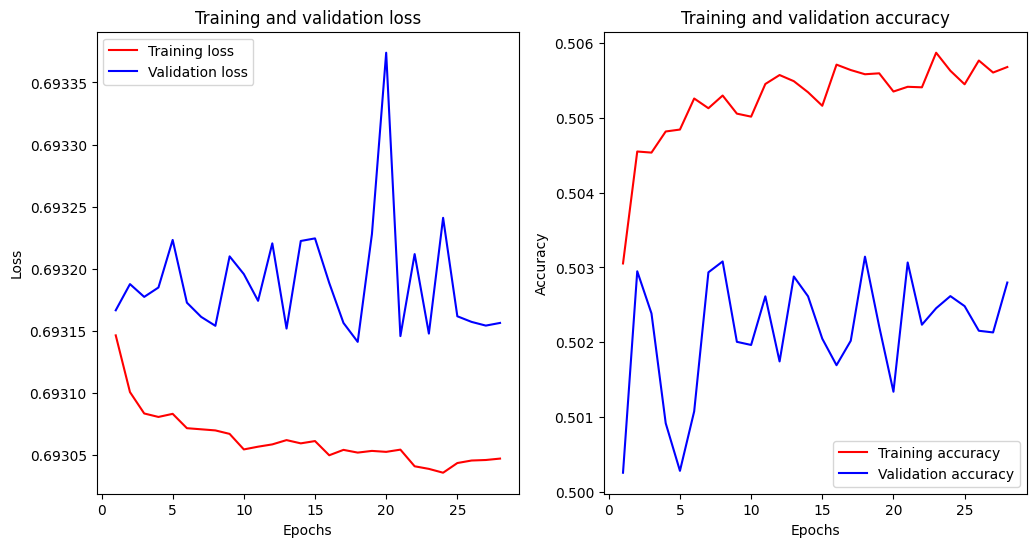

In [7]:


# Turn of printing for PC1??? It prints a lot of shit 
# 185min for PC1, with SESI

# Takes #Epochs * #Tuning parameters * 1min to run  approximately

import LSTM
importlib.reload(LSTM)

# Specify the grid 
# 18ms/step with dropout=0.1 and recurrent_dropout=0.1
# 8ms/step with dropout=0.1 and recurrent_dropout=0.0
grid ={"dropout": [0.1], # Fischer uses 0.1                                                                             # Not much difference   
        "recurrent_dropout": [0.1],     #[0, 0.1], # Fischer uses 0.1 (after hyperparameter tuning)                                                                   # Adding recurrent_dropout makes the model 2.25 times slower   
        "learning_rate": [0.001],          #[0.1, 0.01, 0.001], # 0.001 is default for RMSprop and adam (also seemed best)                                              # learning_rate smaller should take longer to run but I do not see any difference here for values  0.1, 0.01, 0.001, 0.0001
        "batch_size": [64],     #[32, 64], # Default is 32                                                                             # Twice as fast with a twice as big batch size
        #"n_nodes": [64], Fischer has 25 hidden neurons in the LSTM layer
        "optimizer" : ["RMSprop"], # RMSprop Not default but used bij Fisher and good for RNN, default is adam             # adam seems eually fast as RMSprop                
        "sequence_length": [time_steps] # 250 is roughly 1 year of data
        }              

# Make custom loss metric or evaluation metric for tuning


# Trains model on validation set
performances_LSTM, best_model_LSTM = LSTM.LSTM_tune(X_train_lstm, y_train_lstm, X_val_lstm, y_val_lstm, grid, b_sentiment_score, n_past_returns, n_nodes=64) 

# Plot the training and validation loss for the best model also return the best model
LSTM.plot_train_val_loss(performances_LSTM)        #, tuning_metric = "val_loss") # tuning_metric = "val_loss" or "val_accuracy"


# Hoe lang duurt 1 LSTM loop???????????????? Dit is met 1 lookback -> Aan de hand hiervan Tuning par bepalen   -> 14min


In [ ]:
# The number of rows in df_classification, df_predictions and df_classifications_lstm, df_predictions_lstm are not the same yet due to the time_steps

# Creates dataframe which will be filled with all predictions
df_classifications_lstm = df.loc[:, df.columns.isin(["BarDate", "Ticker", "NextdayReturn", "Target"])]
df_classifications_lstm = df_classifications_lstm.tail(len(X_test_lstm))

# Creates dataframe which will be filled with all classifications
df_predictions_lstm = df.loc[:, df.columns.isin(["BarDate", "Ticker", "NextdayReturn", "Target"])]
df_predictions_lstm = df_predictions_lstm.tail(len(X_test_lstm))

In [ ]:
# Takes #Epochs times 5 times 70sec to run

import LSTM
importlib.reload(LSTM)

# Takes 160 minutes to run
ar_predictions_lstm, ar_classifications_lstm, model_lstm = LSTM.LSTM_test(best_model_LSTM, window_size, y_in_sample_lstm, X_in_sample_lstm, y_test_lstm, X_test_lstm, b_sentiment_score, n_past_returns, n_nodes=64) 

# Add predictions to df_predictions
df_predictions_lstm["predictions_lstm"] = ar_predictions_lstm
print(df_predictions_lstm[df_predictions_lstm["predictions_lstm"] > 0.5].count())
# Add predictions to df_predictions
df_classifications_lstm["classifications_lstm"] = ar_classifications_lstm
print(df_classifications_lstm[df_classifications_lstm["classifications_lstm"] == 1].count())

In [ ]:
model_lstm.summary()

In [ ]:
import shap


# Assuming `model_lstm` is your trained LSTM model
# And `X_train` is your training data

# We initialize the javascript for SHAP
shap.initjs()

# We create an explainer. DeepExplainer works well for deep learning models like LSTM.
explainer = shap.DeepExplainer(model_lstm, X_train_lstm)

# Generate SHAP values
shap_values = explainer.shap_values(X_train_lstm)

# Convert the input training set to a numpy array
X_train_array = np.array(X_train_lstm)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_train_array)


In [ ]:
import shap
import numpy as np

# Assuming `model_lstm` is your trained LSTM model
# And `X_train` is your training data

# We initialize the javascript for SHAP
shap.initjs()

# We create an explainer. DeepExplainer works well for deep learning models like LSTM.
explainer = shap.DeepExplainer(model_lstm, X_train)

# Generate SHAP values
shap_values = explainer.shap_values(X_train)

# Convert the input training set to a numpy array
X_train_array = np.array(X_train)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_train_array)


In [ ]:
model_lstm.save('model_lstm.h5')

In [ ]:
# from keras.models import load_model

# loaded_model = load_model('model_lstm.h5')

In [ ]:
#Note: you may need to restart the kernel to use updated packages.
from keras.utils import plot_model

plot_model(model_lstm, to_file='model_lstm.png')

In [ ]:
# Check the number of unique elements of SymbolExchangeCode for every BarDate
test = X_test.groupby("BarDate")["Ticker"].nunique()

# Plot the number of unique elements of SymbolExchangeCode for every BarDate
X_test.groupby("BarDate")["Ticker"].nunique().plot()

In [ ]:
import Evaluation_metrics
importlib.reload(Evaluation_metrics)

predictions_accuracy = Evaluation_metrics.prediction_metrics(df_classifications_lstm, str_model = "lstm", str_single_metric = "Accuracy")

# Add predictions to df_predictions
df_accuracy["LSTM"] = predictions_accuracy

# Model evaluation

# Portfolio backtests

In [ ]:
#### Portfolio part needs to be adjusted, seminar model

In [ ]:
# long_only = True
# short_only = False

# # Number of long and short stocks
# n_both = 20
# n_long = n_both
# n_short = n_both

# Choose which models we want
backtest_models = ["lr", "rf", "gbc", "lstm"]                               #["lr", "rf", "gbc", "lstm]                #"NN1", "NN2", "NN3", "NN4", "NN5"] 

# Choose weighting method (Equal weighted (Equal) or RankBased weighted (RankBased))
# weighting_method = "Equal" 

# Initialize to be filled dataframe with portfolio returns
df_returns_portfolio = pd.DataFrame({"BarDate": df_predictions["BarDate"].unique()})
# Initialize to be filled dataframe with portfolio returns
df_returns_portfolio_lstm = pd.DataFrame({"BarDate": df_predictions_lstm["BarDate"].unique()})

dict_df_metrics = {}	
# # Initialize to be filled dataframe with portfolio metrics
# df_metrics = pd.DataFrame({}, index=['total_return', "mean_return", 'std_dev', 'information_ratio', "appraisal_ratio",
#                                       'max_drawdown', 'max_1_month_loss', 'max_1_year_loss', "turnover"])

# # Cumulative return of stock index, used only in plot
# stockindex_returns_cum = (1 + df_stockindex_returns["Return"]).cumprod() - 1
df_stockindex_returns = None

# Define the colors for the lines
colors = ['red', 'blue', 'green', 'orange', 'red', 'blue', 'green', 'orange']

In [ ]:
# Takes 5:30 to run

# Creates a matrix with all actual returns only 
# The last columns are not the last dates. These all seem NaN values.............Something must change...........................
stocks = df['Ticker'].unique()
returnsMatrix = pd.DataFrame(index=df_predictions['BarDate'].unique(), columns=stocks)
for stock in stocks:
    stock_df = df[df['Ticker'] == stock]
    for index, row in stock_df.iterrows():
        returnsMatrix.at[row['BarDate'], stock] = row['NextdayReturn']

In [ ]:
# Extra metrics take long to run
# Takes +-12min to run

import Portfolio_backtester
importlib.reload(Portfolio_backtester)

# Number of long and short stocks
# for n_both in tqdm([10, 20, 50]):

n_both = 20
n_long = n_both
n_short = n_both
n_constituents = n_both * 2
# Create a loop which first sets long_only = True and then short_only = True and then both = False
for long_only in tqdm([True, False]):
    for short_only in [True, False]:
        if (long_only == True) & (short_only == True):
            continue

        # Plot the cumulative portfolio return
        plt.subplots(figsize=(20,10))
        # Dictionary to be filled with weight matrices
        weight_matrix_dict = {}
        # Use this for color of the lines
        i = 0
        for weighting_method in tqdm(["Equal", "RankBased"]):
            dict_df_metrics[f"{weighting_method}_{n_both}"] = pd.DataFrame({}, index=['total_return', "mean_return", 'std_dev', 'information_ratio', "appraisal_ratio", 'max_drawdown', 'max_1_month_loss', 'max_1_year_loss', "turnover"])
            for backtest_model in tqdm(backtest_models
                # Predictions are now stored in two different objects
                if backtest_model == "lstm":
                    df_predictions_backtest = df_predictions_lstm
                    df_returns_portfolio_backtest = df_returns_portfolio_lstm
                else:
                    df_predictions_backtest = df_predictions
                    df_returns_portfolio_backtest = df_returns_portfolio

                predictions_test_set, df_returns_portfolio_backtest, str_returns_portfolio_cum, str_logreturns_portfolio_cum, weightMatrix = Portfolio_backtester.backtest(df_predictions_backtest,n_long,n_short,backtest_model,
                                                                                weighting_method, df_returns_portfolio_backtest, returnsMatrix, long_only, short_only)
                weight_matrix_dict.update({backtest_model: weightMatrix})
          
                if weighting_method == "Equal":
                    plt.plot(pd.to_datetime(df_returns_portfolio_backtest["BarDate"]), df_returns_portfolio_backtest[str_logreturns_portfolio_cum], color = colors[i], label=str(f"{backtest_model} {weighting_method}"))
                elif(weighting_method == "RankBased"):
                    plt.plot(pd.to_datetime(df_returns_portfolio_backtest["BarDate"]), df_returns_portfolio_backtest[str_logreturns_portfolio_cum], color = colors[i], linestyle = '--', label=str(f"{backtest_model} {weighting_method}"))
                # Gives metrics
                dict_df_metrics[f"{weighting_method}_{n_both}"] = Portfolio_backtester.metrics(df_returns_portfolio_backtest, backtest_model, dict_df_metrics[f"{weighting_method}_{n_both}"], df_stockindex_returns, returnsMatrix, weightMatrix)
                i = i + 1

        #plt.plot(pd.to_datetime(df_stockindex_returns["Date"]), stockindex_returns_cum) # Plots long only index
        plt.axvspan(datetime.datetime.strptime("29/02/2020", '%d/%m/%Y').date(), datetime.datetime.strptime("31/03/2020", '%d/%m/%Y').date(), color="grey", alpha=0.5)
        # plt.axvspan(datetime.datetime.strptime("31/12/2007", '%d/%m/%Y').date(), datetime.datetime.strptime("31/05/2009", '%d/%m/%Y').date(), color="grey", alpha=0.5)

        plt.xlabel(xlabel="Date", fontsize = "x-large")
        if long_only == True:
            plt.ylabel(ylabel="Cumulative portfolio (long) logreturns", fontsize = "x-large")
        if short_only == True:
            plt.ylabel(ylabel="Cumulative portfolio (short) logreturns", fontsize = "x-large")
        if (long_only == False) & (short_only == False):
            plt.ylabel(ylabel="Cumulative portfolio logreturns", fontsize = "x-large")
        plt.title(label=f"Cumulative {n_constituents}-stock portfolio logreturns", fontsize = "xx-large")  
        plt.grid(linestyle='dashed', linewidth=0.5)
        plt.legend(['lr', 'rf', 'gb', 'lstm', 'lr_rank', 'rf_rank', 'gb_rank', 'lstm_rank'] , loc = 'upper center', ncols = 4, fontsize = 'large')    # Without specifying loc it chooses the best location
        plt.show()


print(dict_df_metrics)

## Save point

In [ ]:
# Change for new file!!!!!!!!!!!!!!!!!!!!!!!!!!
b_sentiment_score 
stockindex = "SPH"
LSTM_model_type = "LSTM_model_1"
time_steps
# n_both
# weighting_method

In [ ]:
from joblib import dump, load

# Creating the directory name
directory = r"C:\Users\BasPeeters\OneDrive - FactorOrange.capital\Master Thesis\Dataframes and output"
folder_name = f"{stockindex}_SESI={b_sentiment_score}_{LSTM_model_type}_time_steps = {time_steps}"
full_directory = os.path.join(directory, folder_name)

# Create the directory if it doesn't exist
if not os.path.exists(full_directory):
    os.makedirs(full_directory)

# Save your dataframes using pickle
df_classifications_lstm.to_pickle(os.path.join(full_directory, "df_classifications_lstm.pkl"))
df_predictions_lstm.to_pickle(os.path.join(full_directory, "df_predictions_lstm.pkl"))
df_predictions.to_pickle(os.path.join(full_directory, "df_predictions.pkl"))
df_classifications.to_pickle(os.path.join(full_directory, "df_classifications.pkl"))

# Save metrics and to csv
df_accuracy.to_csv(os.path.join(full_directory, "df_accuracy.csv"))
for key in dict_df_metrics:
    dict_df_metrics[key].to_csv(os.path.join(full_directory, f'df_metrics_{key}.csv'))

# try:
#     df_returns_portfolio_lstm.to_pickle(os.path.join(full_directory, f"df_returns_portfolio_lstm_n_stock={n_both}_weighting_method={weighting_method}.pkl"))
# except:
#     print("df_returns_portfolio_lstm does not exist")
# try:
#     df_returns_portfolio.to_pickle(os.path.join(full_directory, f"df_returns_portfolio_n_stock={n_both}_weighting_method={weighting_method}.pkl"))
# except:
#     print("df_returns_portfolio_ does not exist")

try: 
    # Save your models
    dump(best_model_LSTM, os.path.join(full_directory, 'best_model_LSTM.joblib'))
except:
    print("best_model_LSTM does not exist")	
try:
    dump(best_model_GBC, os.path.join(full_directory, 'best_model_GBC.joblib'))
except:
    print("best_model_GBC does not exist")
try:
    dump(best_model_RF, os.path.join(full_directory, 'best_model_RF.joblib'))
except:
    print("best_model_RF does not exist")

    
print(f"All data is saved to {full_directory}")

## load point

In [ ]:
from joblib import load

# Creating the directory name
directory = r"C:\Users\BasPeeters\OneDrive - FactorOrange.capital\Master Thesis\Dataframes and output"
folder_name = f"{stockindex}_SESI={b_sentiment_score}_{LSTM_model_type}_time_steps = {time_steps}"
full_directory = os.path.join(directory, folder_name)

# dict_df_metrics = pd.read_pickle(os.path.join(full_directory, "dict_df_metrics.pkl"))
df_classifications_lstm = pd.read_pickle(os.path.join(full_directory, "df_classifications_lstm.pkl"))
df_predictions_lstm = pd.read_pickle(os.path.join(full_directory, "df_predictions_lstm.pkl"))
df_predictions = pd.read_pickle(os.path.join(full_directory, "df_predictions.pkl"))
df_classifications = pd.read_pickle(os.path.join(full_directory, "df_classifications.pkl"))
# df_accuracy = pd.read_pickle(os.path.join(full_directory, "df_accuracy.pkl"))
# df_returns_portfolio_lstm = pd.read_pickle(os.path.join(full_directory, f"df_returns_portfolio_lstm_n_stock={n_both}_weighting_method={weighting_method}.pkl"))
# df_returns_portfolio = pd.read_pickle(os.path.join(full_directory, f"df_returns_portfolio_n_stock={n_both}_weighting_method={weighting_method}.pkl"))

df_accuracy = pd.read_csv(os.path.join(full_directory, "df_accuracy.csv"))
dict_df_metrics = {}
for key in ["Equal_20", "RankBased_20"]:
    dict_df_metrics[key] = pd.read_csv(os.path.join(full_directory, f'df_metrics_{key}.csv'))

# best_model_LSTM = load(os.path.join(full_directory, "best_model_LSTM.joblib"))
# best_model_GBC = load(os.path.join(full_directory, "best_model_GBC.joblib"))
# best_model_RF = load(os.path.join(full_directory, "best_model_RF.joblib"))

## This is nice

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your data in the following format:
# data = {
#     'Portfolio1': {'10': {'Accuracy': 0.8, 'Sharpe Ratio': 1.2, 'Std Dev': 0.1, 'Return': 0.05},
#                    '20': {'Accuracy': 0.75, 'Sharpe Ratio': 1.1, 'Std Dev': 0.15, 'Return': 0.06},
#                    '30': {'Accuracy': 0.85, 'Sharpe Ratio': 1.3, 'Std Dev': 0.12, 'Return': 0.07}},
#     'Portfolio2': {'10': {'Accuracy': 0.9, 'Sharpe Ratio': 1.4, 'Std Dev': 0.11, 'Return': 0.08},
#                    '20': {'Accuracy': 0.88, 'Sharpe Ratio': 1.5, 'Std Dev': 0.13, 'Return': 0.09},
#                    '30': {'Accuracy': 0.92, 'Sharpe Ratio': 1.6, 'Std Dev': 0.14, 'Return': 0.1}},
#     ...
# }

data = {
    'Portfolio1': {'10': {'Accuracy': 0.8, 'Sharpe Ratio': 1.2, 'Std Dev': 0.1, 'Return': 0.05},
                   '20': {'Accuracy': 0.75, 'Sharpe Ratio': 1.1, 'Std Dev': 0.15, 'Return': 0.06},
                   '30': {'Accuracy': 0.85, 'Sharpe Ratio': 1.3, 'Std Dev': 0.12, 'Return': 0.07}},
    'Portfolio2': {'10': {'Accuracy': 0.9, 'Sharpe Ratio': 1.4, 'Std Dev': 0.11, 'Return': 0.08},
                   '20': {'Accuracy': 0.88, 'Sharpe Ratio': 1.5, 'Std Dev': 0.13, 'Return': 0.09},
                   '30': {'Accuracy': 0.92, 'Sharpe Ratio': 1.6, 'Std Dev': 0.14, 'Return': 0.1}},
    # Add more portfolios as needed
}

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Add more colors if you have more than 7 portfolios

fig, ax = plt.subplots(4, 3, figsize=(10, 10))

# Plotting
for i, metric in enumerate(['Accuracy', 'Sharpe Ratio', 'Std Dev', 'Return']):
    for j, num_stocks in enumerate(['10', '20', '30']):
        ax[i, j].bar(data.keys(), [v[num_stocks][metric] for v in data.values()], color=colors)
        if i == 0:
            ax[i, j].set_title(f'{num_stocks} stocks')
        if j == 0:
            ax[i, j].set_ylabel(metric)

plt.tight_layout()
plt.show()


In [ ]:
# Test